In [1]:
using JUDI, PyPlot, LinearAlgebra, ImageFiltering

## Traditional

In [2]:
n = (101, 101)  # Number of grid point (nx, nz)
d = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
o = (0., 0.);  # What is the location of the top left corner. This is necessary to define
# velocities
v = 1.5f0 * ones(Float32, n)
v[:, 31:66] .= 1.5f0 + 0.5f0
v[:, 66:end] .= 1.5f0 + 1.5f0
v[41:61, 36:56] .= 1.5f0 + 1.0f0;

# Create initial model and smooth the boundaries
v0 = imfilter(v, Kernel.gaussian((5,5)));

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m0 - m);

# Setup model structure
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0);

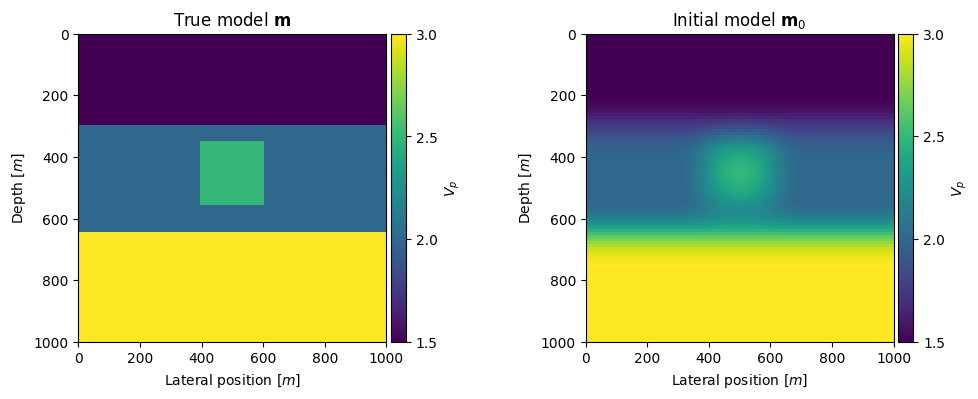

In [3]:
fig=figure(figsize=(12,4));
subplot(121)
im = imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p$")
xlabel(L"Lateral position $[m]$")
ylabel(L"Depth $[m]$")
title(L"True model $\mathbf{m}$")
subplot(122)
im = imshow(v0', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p$")
xlabel(L"Lateral position $[m]$")
ylabel(L"Depth $[m]$")
title(L"Initial model $\mathbf{m}_0$")
display(fig)

### 2 source experiment

In [4]:
nsrc = 2
nxrec = 100
xrec = range(0f0, stop=(n[1]-1)*d[1], length=nxrec)
yrec = 0f0 # Cero para el eje y, 2D
zrec = range(30f0, stop=30f0, length=nxrec)

timeD = 2000f0
dtD = 4f0

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

xsrc = convertToCell([350, 700])
ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc))
zsrc = convertToCell(range(30f0, stop=30f0, length=nsrc))

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)

GeometryIC{Float32} wiht 2 sources


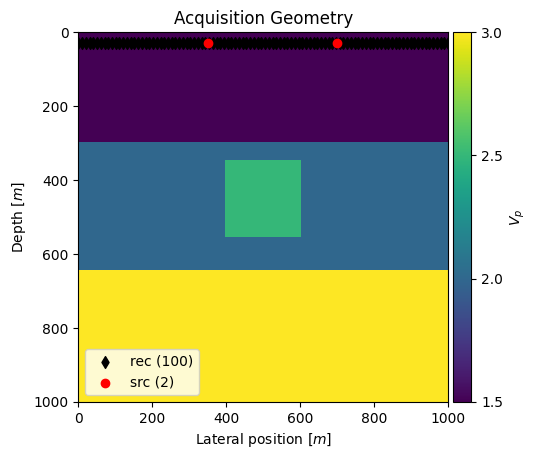

In [5]:
fig=figure();
im = imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
scatter(xrec, zrec, label="rec (100)", color="black", marker="d")
scatter(xsrc, zsrc, label="src (2)", color="red")
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"V_p")
xlabel(L"Lateral position $[m]$")
ylabel(L"Depth $[m]$")
title("Acquisition Geometry")
legend();
display(fig)

In [6]:
f0 = 0.01f0
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 2 sources


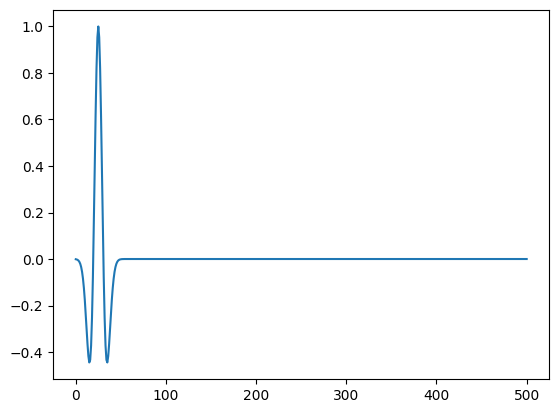

In [7]:
fig=figure()
plot(wavelet)
display(fig)

In [8]:
opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing
# Operadores
Pr = judiProjection(recGeometry)
F = judiModeling(model; options=opt)
F0 = judiModeling(model0; options=opt)
Ps = judiProjection(srcGeometry)
q = judiVector(srcGeometry, wavelet)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)


In [9]:
d_obs = Pr*F*adjoint(Ps)*q

Building forward operator
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


judiVector{Float32, Matrix{Float32}} with 2 sources


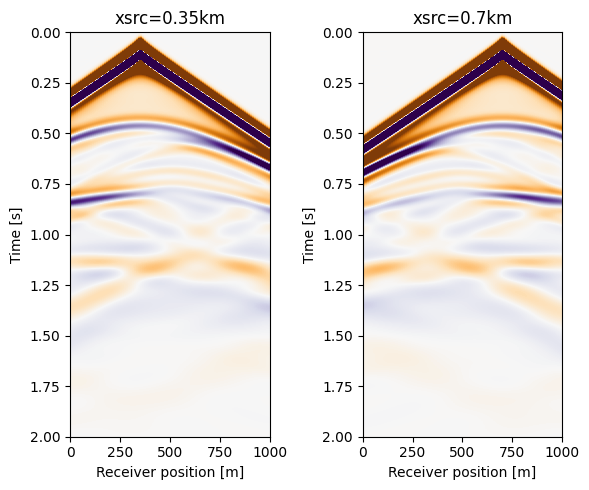

In [10]:
fig=figure(figsize=(6, 5)) #, dpi=300
for i=1:2
    subplot(1, 2, i)
    imshow(d_obs.data[i], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
    xlabel("Receiver position [m]")
    ylabel("Time [s]")
    title("xsrc=$(round(1f-3xsrc[i][1]; digits = 2))km")
end

tight_layout()
display(fig)

___
## Sim source

In [11]:
nsrc = 1
nxrec = 100
xrec = range(0f0, stop=(n[1]-1)*d[1], length=nxrec)
yrec = 0f0 # Cero para el eje y, 2D
zrec = range(30f0, stop=30f0, length=nxrec)

timeR = 2000f0
dtR = 4f0

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt = dtR, t = timeR)

GeometryIC{Float32} wiht 1 sources


In [12]:
## Set up source geometry
xsrc = [350f0, 750f0]	# two simultaneous sources
ysrc = 0f0
zsrc = [30f0, 30f0]

# Source sampling and number of time steps
timeS = 2000f0
dtS = 4f0

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt = dtS, t = timeS)

GeometryIC{Float32} wiht 1 sources


In [28]:
f0 = 0.01	# source peak frequencies
q = ricker_wavelet(1000f0, dtS, f0)  # 1000 ms wavelet

# Create two source functions with different time shifts of q
wavelet1 = zeros(srcGeometry.nt[1])
wavelet1[1:1+length(q)-1] = q
wavelet2 = zeros(srcGeometry.nt[1])
wavelet2[70:70+length(q)-1] = q
wavelet = [wavelet1 wavelet2];	# Collect all wavelets;

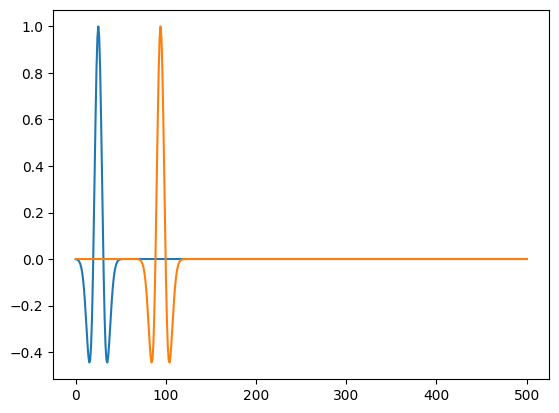

In [30]:
fig=figure()
plot(wavelet)
display(fig)

In [31]:
opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing
Pr = judiProjection(recGeometry)
F = judiModeling(model; options=opt)
F0 = judiModeling(model0; options=opt)
Ps = judiProjection(srcGeometry)
q = judiVector(srcGeometry, wavelet)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)


In [44]:
d_sim = Pr*F*adjoint(Ps)*q

In [ ]:
fig = figure(); 
imshow(d_sim[1], vmin = -1e1, vmax = 1e1, cmap = "seismic"); 
title("Simultaneous shot with two sources")
display(fig)